In [1]:
# imports
%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, TransitionMatrixGHMM, ZeroOneR, Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs

import numpy as np
import torch
import plotly.express as px
import pathlib

from sklearn.linear_model import LinearRegression
from torch.utils.data import IterableDataset, DataLoader

from torch.nn.functional import cross_entropy
# train!
from tqdm.autonotebook import tqdm


from transformer_lens import HookedTransformer, HookedTransformerConfig # type: ignore
from typing import Optional

In [2]:
from epsilon_transformers.process.processes import Process
from typing import Tuple

def create_hooked_transformer(model_cfg: dict, device: torch.device, seed: Optional[int] = None
    ) -> HookedTransformer:
        config = HookedTransformerConfig(
            d_model=model_cfg["d_model"],
            d_head=model_cfg["d_head"],
            n_layers=model_cfg["n_layers"],
            n_ctx=model_cfg["n_ctx"],
            n_heads=model_cfg["n_heads"],
            d_mlp=4 * model_cfg["d_model"],
            d_vocab=3,
            attn_only=model_cfg["attn_only"],
            seed=seed,
            device=device,
            act_fn=model_cfg["act_fn"],
            positional_embedding_type=model_cfg["positional_embedding_type"],
            normalization_type=model_cfg["normalization_type"],
        )
        return HookedTransformer(config).to(device)

def generate_all_seqs(process: Process, seq_len: int, bos: bool = True) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Generate all possible sequences and their probabilities for a given process and sequence length.

    Args:
        process (Process): The process to generate sequences from.
        seq_len (int): The length of sequences to generate.
        bos (bool): Whether to include a beginning-of-sequence token. Defaults to True.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
            - transformer_inputs: All possible sequences.
            - probs: Probability of each sequence.
            - loss_lower_bound: Loss lower bound for each context window position.

    Raises:
        ValueError: If the sum of probabilities is not approximately 1.0.
    """
    # Adjust depths and lengths based on BOS token
    msp_depth = seq_len + (1 if bos else 2)
    final_seq_len = seq_len - (1 if bos else 0)
    bos_token = process.vocab_len if bos else None

    # Generate Mixed State Presentation
    msp = process.derive_mixed_state_presentation(depth=msp_depth)
    paths, probs = msp.get_paths_and_probs(depth=final_seq_len)
    myopic_entropy = msp.myopic_entropy

    # Convert to tensors
    transformer_inputs = torch.tensor(paths, dtype=torch.int32)
    probs = torch.tensor(probs, dtype=torch.float32)

    # Add BOS token if required
    if bos:
        bos_column = torch.full((len(paths), 1), bos_token, dtype=torch.int32)
        transformer_inputs = torch.cat([bos_column, transformer_inputs], dim=1)
        loss_lower_bound = myopic_entropy[:-1]
    else:
        loss_lower_bound = myopic_entropy[1:-1]

    # Validate probabilities
    if not torch.isclose(probs.sum(), torch.tensor(1.0), atol=1e-6):
        raise ValueError(f"Sum of probabilities is {probs.sum().item():.6f}, expected 1.0")

    return transformer_inputs, probs, loss_lower_bound

# Create an iterable batch generator
class BatchGenerator:
    def __init__(self, transformer_inputs, probs, cfg):
        self.transformer_inputs = transformer_inputs
        self.probs = probs
        self.cfg = cfg

    def __len__(self):
        return self.cfg["batches_per_epoch"]

    def __iter__(self):
        total_samples = self.cfg["batches_per_epoch"] * self.cfg["batch_size"]
        sample_inds = torch.multinomial(self.probs, total_samples, replacement=True)
        sample_inds = sample_inds.reshape(self.cfg["batches_per_epoch"], self.cfg["batch_size"])

        for batch_indices in sample_inds:
            batch = self.transformer_inputs[batch_indices]
            X, Y = batch[:, :-1], batch[:, 1:]
            yield X, Y

    def validation_data(self):
        total_samples = self.transformer_inputs.shape[0]
        for start_idx in range(0, total_samples, self.cfg["batch_size"]):
            end_idx = min(start_idx + self.cfg["batch_size"], total_samples)
            batch = self.transformer_inputs[start_idx:end_idx]
            batch_probs = self.probs[start_idx:end_idx]
            X, Y = batch[:, :-1], batch[:, 1:]
            yield X, Y, batch_probs



In [4]:

# Configuration
cfg = {
    "seq_len": 8,
    "batch_size": 256,
    "batches_per_epoch": 1000,
    "device": torch.device("mps" if torch.backends.mps.is_available() else "cpu")
}

model_cfg = {
    "d_model": 32,
    "d_head": 8,
    "n_layers": 1,
    "n_ctx": cfg["seq_len"],
    "n_heads": 4,
    "attn_only": False,
    "act_fn": "relu",
    "positional_embedding_type": "standard",
    "normalization_type": "LN",
}

# Process initialization
process = TransitionMatrixGHMM(RRXOR().transition_matrix)
process.name = "RRXOR"

# Generate sequences and probabilities
transformer_inputs, probs, loss_lower_bound = generate_all_seqs(process, cfg["seq_len"] + 1, bos=False)
transformer_inputs = transformer_inputs.to(cfg["device"])
probs = probs.to(cfg["device"])

# Create the batch generator
batch_generator = BatchGenerator(transformer_inputs, probs, cfg)

model = create_hooked_transformer(model_cfg, cfg["device"])


optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

mean_loss_lower_bound = np.mean(loss_lower_bound)


def train_batch(model, optimizer, X, Y):
    """
    Perform a single training step on a batch of data.

    Args:
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        X (torch.Tensor): Input tensor of shape (batch_size, seq_len).
        Y (torch.Tensor): Target tensor of shape (batch_size, seq_len).

    Returns:
        float: The average loss for this batch.
    """

    # Clear gradients
    optimizer.zero_grad(set_to_none=True)

    # Forward pass
    logits = model(X)
    batch_size, seq_len, vocab_size = logits.shape
    logits = logits.reshape(batch_size * seq_len, vocab_size)
    Y = Y.reshape(batch_size * seq_len)

    # Compute loss
    loss = cross_entropy(logits, Y, reduction='none')
    loss = loss.view(batch_size, seq_len)

    # Calculate average loss per position and total loss
    loss_per_position = loss.mean(dim=0)
    total_loss = loss_per_position.mean()

    # Backward pass and optimization
    total_loss.backward()
    optimizer.step()

    return loss.item()

for n_epoch in tqdm(range(10), desc="Epochs"):
    batch_iterator = tqdm(batch_generator, desc="Batches", leave=False)
    for X, Y in batch_iterator:
        batch_loss = train_batch(model, optimizer, X, Y)
        batch_iterator.set_postfix({"Loss": batch_loss/mean_loss_lower_bound}, refresh=False)

Moving model to device:  mps


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [160]:
X

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 1, 1, 0],
        [0, 1, 0,  ..., 1, 1, 0],
        ...,
        [0, 0, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 1]], device='mps:0', dtype=torch.int32)

In [161]:
n_vocab = 3
with torch.no_grad():
    X, Y = transformer_inputs[:, :-1], transformer_inputs[:, 1:]
    logits = model(X) # (n_samples, seq_len, n_vocab)
    logits = logits.reshape(-1, n_vocab) # (n_samples * seq_len, n_vocab)
    Y = Y.reshape(-1) # (n_samples * seq_len)
    loss = cross_entropy(logits, Y, reduction='none')
    loss = loss.reshape(X.shape[0], -1)
    print(probs.shape, loss.shape)
    loss = probs.unsqueeze(1) * loss
    loss = loss.sum(dim=0)
    print(loss)




torch.Size([260]) torch.Size([260, 8])
tensor([0.6944, 0.6378, 0.6298, 0.6115, 0.6046, 0.6221, 0.6158, 0.6138],
       device='mps:0')


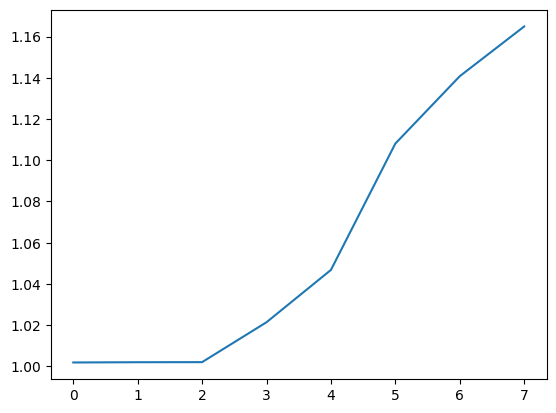

In [162]:
import matplotlib.pyplot as plt
plt.plot(loss.detach().cpu().numpy()/myopic_entropy)

In [147]:
myopic_entropy.shape

(9,)

In [ ]:
probs.unsqueeze(1).shape

torch.Size([19683, 1])

In [ ]:
loss.shape

torch.Size([19682, 9])

In [ ]:
result = probs.unsqueeze(1) * loss

RuntimeError: The size of tensor a (19683) must match the size of tensor b (19682) at non-singleton dimension 0

In [ ]:
result = probs[:loss.shape[0]].unsqueeze(1) * loss
result = result.sum()

In [ ]:
result.shape

torch.Size([9])

In [ ]:
result/9

tensor(1.0836, device='mps:0', grad_fn=<DivBackward0>)

In [ ]:
myopic_entropy[1:].shape

(7,)